# Finding the $k$-Densest Subgraph through SDP relaxations : from theory to practice

#### Main reference : *Polynomial integrality gaps for strong SDP relaxations of Densest k-subgraph*, Bhaskara, Charikar, Guruswami [2011]

In [1]:
import numpy as np, pandas as pd
import networkx as nx
from cvxpy import *
import time
import matplotlib.pyplot as plt

## I - Introduction

## 1.1) Context and problem

Given some general graph $G(V,E)$ where $V$ and $E$ are the set of vertices and edges, the combinatorial problem of finding a $k$-densest subgraph, i.e. a subgraph of $G$ having at most $k \in [1,|V|]$ vertices and with the maximum number of edges, has been thoroughly studied in computer sciences and approximation algorithms literatures. This problem has in fact many applications in network analysis where one may for instance be interested in detecting communities in social networks, identifying protein families or more generally investigating theoretical relationships between instances in a sample.

As many combinatorial problems, this optimization problem is kind of a hard problem since the number of possible edges grows exponentially with the number of vertices. Actually, it is NP-hard in general graphs as it generalizes the max-clique problem of finding a subset of fully connected vertices with the largest possible number of vertices, which is itself NP-hard. This means that only approximation algorithms will be available in general. Actually, most of those current techniques rely on re-formulations of the problem as convex programming problems called "relaxations" because they are different from the original problem but they yield an approximation of the solution that can be satisfying under some conditions up to a certain accuracy (for instance, think of the $\ell_1$ relaxation of the *Basis Pursuit* algorithm for the reconstruction of a $s$-sparse vector). 

The key question addressed by the literature is then : how hard is it for these algorithms to deliver an approximated solution close enough to the true solution of the problem ? Or, recasted differently, how close to the solution can we expect our approximated solution to be for a fixed computational cost ? While Linear Programming (LP) relaxations have been thoroughly studied, SemiDefinite Programming (SDP) relaxations are part of recent development in approximation algorithms. 

The main article under study, *"Polynomial integrality gaps for strong SDP relaxations of Densest k-subgraph"* from Bhaskara et al. (2011), investigates from a theoretical point of view the extent to which lift-and-project relaxations of the *Densest k-subgraph* - i.e. particular hierarchies of LP/SDP relaxations - are able to deliver approximated solutions close to the true solution of the problem. More precisely, it gives polynomial lower bounds for the integrality gap in various minorated (and strong) regimes of relaxations rounds in both the Lasserre and Sherali-Adams hierarchies. It turns out that these lower bounds, somewhat negative results for SDP relaxations, are much stronger than the very weak hardness bounds known for the problem. Indeed, the known inapproximability results for the *Densest k-subgraph* (DkS) problem are relatively limited because they only rule out constant factor approximations and therefore maintain a huge gap with the ones obtained by the  best current approximation algorithm [BBC$^+$10] (approximation in $\mathcal{O}(n^{1/4 + \epsilon})$ for some relaxation of the problem where $n$ would be the number of vertices in the original graph). This latter observation supports both the hardness of the problem and a limited understanding. Therefore, these new bounds are strong because they show that even adding increasingly more constraints does not translate into an improved approximation performance. Moreover, the two main results for each of the considered hierarchies suggest that beating the best known $n^{1/4}$ factor is in fact impossible for current techniques.  More generally, they suggest that the *Densest k-subgraph* problem is in fact harder than some other NP-hard problems (such as Unique Games or Small Set Expansion) that can be solved by using a constant number of rounds of the Lasserre hierarchy.

## 1.2) Key concepts and related definitions

Before going further, we need to introduce some key concepts related to SDP relaxations and approximation algorithms in order for the reader to get a good understanding of the problem at stake, the results and the tools used to assess approximation quality :
- Integrality gap 
- Integer programming and LP relaxations
- "Lift-and-project" methods and SDP relaxations
- Sherali-Adams and Lasserre hierarchies
- Small Set Expansion $\to$ Unique Game Conjecture
- Some definitions

** Integrality Gap **

It is the ratio between the SDP relaxation optimum and the original combinatorial problem solution. It is always defined so that it is at least 1. Sometimes, one can study the ratio between the SDP optimum and a rounded solution (see rounding algorithm).

** Integer Programming (IP) and Linear Programing (LP) relaxations**

*"An integer programming problem is a mathematical optimization or feasibility program in which some or all of the variables are restricted to be integers. In many settings the term refers to integer linear programming (ILP), in which the objective function and the constraints (other than the integer constraints) are linear. Integer programming is NP-complete."* (Wikipedia).

DkS is an IP problem.

To solve DkS we can first consider two natural LP relaxations :

\begin{alignat}{2}
&                  & LP1 \text{ (natural) } &                      & \qquad &       & LP2 \text{ (maximize the minimum degree) } & \\
\hline
&\!\max            &\qquad& \sum_{(i,j) \in E(G)}x_{ij} &        &\!\max & \qquad& d \\
&\text{subject to} &      & \sum_{i \in V} x_i \leq k,\label{eq:constraint1} & &\text{subject to} &                  & \sum_{i\in V}x_{i} \leq k, \quad \text{and}\\
&                  &      &  \forall i,j \in V, \quad 0 \leq x_{ij} \leq x_i \leq 1 \label{eq:constraint2} &     &      &                       \exists\{x_{ij} | i, j \in V\} \text{, s.t. }       &   \\
&                  &      &          &                 &      &  
                   & \forall i \in V \quad  \sum_{j \in \Gamma(i)}x_{ij} \geq d x_i \\
&                  &      &   \label{eq:constraint4} &                  &      &  
                   & \forall i,j \in V \quad x_{ij} = x_{ji} \\
                   &                  &      &   \label{eq:constraint10} &                  &      &  
                   & \forall i,j \in V \quad 0 \leq x_{ij} \leq x_i \leq 1 \\
\hline
\end{alignat}

$LP1$ seeks to find the maximum number of edges for a given size $k$ while $LP2$ is a bit more refined. It seeks to maximize the
minimum possible degree.

In our problem we will consider interactions between variables and products (vertices and edges) so it will be rather easily recasted in a quadratic problem.

** "Lift-and-project" method (Lovasz-Schrijver Hierarchies) [CT 11, Mal07] **

The basic idea is to replace the product $x_ix_j$ (or $x_{ij}$) of our Boolean quadratic optimization problem by another variable $X_{ij} = x_ix_j$ associated to the matrix $X = xx^\top$ : the space $\mathbb{R}^n$ is thus “lifted” to the space $\mathcal{S}_n$ of symmetric matrices.

Lovasz-Schrijver give two versions of a "Lift-and-project" method. It can be seen as an operator which, once applied to a convex programming relaxation $\mathcal{P}$ (such as $LP1$ or $LP2$) of a 0/1 integer linear program produces a tighter relaxation. A tighter relaxation means that we have added constraints that are valid only for candidates to the solution of the integer problem. If our constraints are neither linear nor convex we instead "approximate" our condition by implied linear or Semi-definite positive (SDP) conditions. Weak version of the method is $LS$ which adds auxiliary variables and linear inequalities, the projection on the original variables is denoted $N(\mathcal{P})$. $LS_+$ adds SDP constraints as well ($N_+(\mathcal{P})$).

SemiDefinite Programing (SDP) relaxations will therefore be LP relaxations or quadratic problems where we have added one or many SDP constraints of the type : $X \succcurlyeq 0$.


** Lasserre and Sherali-Adams hierarchies **

They define sequences of SDP relaxations for a combinatorial problem (often related to integer programming), which are increasingly more constrained. A program obtained by applying $r$ rounds of these hierarchies can be solved in $n^{\mathcal{O}(r)}$ time, which leads to approximation algorithms that can run in polynomial time when the number of rounds is constant. It is worth noting that the integrality gap becomes 1 after $n$ levels of those hierarchies.

For some problems, known SDP based algorithms can be derived by using a constant number of rounds. For others, it is sometimes useful to consider an increasing number of rounds in order to obtain a better approximation. There is thus a trade-off between the "relaxation regime" and the accuracy in the approximation obtained, such as summarized by the integrality gap.

The hierarchies are described extensively in [CT11].

In the DkS case, both hierarchies are :

- Sherali-Adams for $r$ relaxation levels ($SA_r$) :


\begin{alignat}{2}
&\!\max & \qquad& d\\
&\text{subject to} &   \exists\{x_S | S \subseteq V, |S| \leq r\} \text{ s.t. } x_{\varnothing} = 1 \text{ and} & \\
& \forall S, T \subseteq V \text{ s.t.} |S| + |T| \leq r :   & \\
&          & \sum_{i \in V} \sum_{J \subseteq T}(-1)^{|J|}x_{S \cup J \cup \{i\}} \leq k \sum_{J \subseteq T}(-1)^|J|x_{S \cup J} & & \text{(1)} \\
&          & \forall i \in V \sum_{i \in \Gamma(i)} \sum_{J \subseteq T}(-1)^{|J|}x_{S \cup J \cup \{i,j\}} \geq d \sum_{J \subseteq T}(-1)^{|J|}x_{S \cup J \cup \{i\}}  & & \text{(2)}\\
&        &   0 \leq \sum_{J \subseteq T}(-1)^{|J|}x_{S \cup J} \leq 1 & & \text{(3)}
\end{alignat}

- Lassere for $r$ relaxation levels ($LA_r$) :

Introduce a vector $U_S$ for each subset $S \subseteq V$ with $|S| \leq r$. $U_S = U_{\varnothing}$ if every vertex in $S$ belongs to the DkS, $U_S = 0$ otherwise. $||U_S||^2$ corresponds to valid LP values $x_S$ for the SA relaxation.

\begin{alignat}{2}
&\!\max &\qquad& \sum_{(u,v) \in E} ||U_{\{u,v\}}||^2 \\
&\text{subject to} &   & \langle U_{S_1}, U_{S_2} \rangle \geq 0 \text{ for all } S_1, S_2 \\
&                  &   & \langle U_{S_1}, U_{S_2} \rangle = \langle U_{S_3}, U_{S_4} \rangle \text{ when } S_1 \cup S_2 = S_3 \cup S_4 \\
&                  &  & \sum_{u \in V} \langle U_{\{v\}}, U_S \rangle \leq k ||U_S||^2 \text{ for all } S \\
&                  &  & ||U_{\varnothing}||^2 = 1
\end{alignat}

** SSE and UG conjectures : **

Not polynomial-time solvable problems related to DsK and which support the hardness of DkS.


** Some other definitions **
-  $\Omega$ is the opposit of $\mathcal{O}$ : $f(n) = \Omega(g(n))$ means that $f$ is minorated in absolute value by a constant times $|g(n)|$,
- $G = (V,E)$ refers to a graph instance of the DkS on $n$ vertices. $V$ is the set of vertices, $E$ the set of edges,
- degree of a graph vertex : number of edges connected to this vertex,
- $d(H)$ is the average degree of any $H\subseteq G$, $\Gamma_H(v)$ is the set of neighbors of $v$ in $H$,
- the density $d_G$ of a graph $G(V; E)$ is its average degree. That is, $d_G = 2 \frac{|E|}{|V|}$. When $G$ is clear from the context, we denote the density by $d$.
- The minimal Steiner tree of S : it is the tree T ⊂ G of minimum total edge weight such that T includes all vertices in S. While a spanning tree spans all vertices of a given graph, a Steiner tree spans a given subset of vertices. In the Steiner minimal tree problem, the vertices are divided into two parts: terminals and nonterminal vertices. The terminals are the given vertices which must be included in the solution. The cost of a Steiner tree is defined as the total edge weight. A Steiner tree may contain some nonterminal vertices to reduce the cost. Let V be a set of vertices. In general, we are given a set L ⊂ V of terminals and a metric defining the distance between any two vertices in V . The objective is to find a connected subgraph spanning all the terminals of minimal total cost.


The remainder of our report is organized as follows : in **Section II** we summarize the main theoretical results and try to give the main ideas the proofs and complete them in some cases. 

Then, in **Section III**, we study and replicate replicate the specific extension of Malick-Roupin that relies on a dualization of the original SDP relaxation in order to be able to manage the tradeoff between precision and running time.

Finally, we discuss and point out some limitations in **Section IV**.

## II - Main inapproximability results for the Lasserre and Sherali Adams Hierarchies

The trade-off in SDP relaxations and hierarchies must be understood in the following way : it is costly to go through several relaxations (rounds) so that it will be interesting to do so only if this translates into a significant decrease in the integrality gap. The first goal here is to obtain lower bounds for the integrality gap as a function of the number of rounds in the considered hierarchies. It is interesting because it allows to rule out many algorithms unconditionnally to P = NP.

There are two main results : one for SA hierarchies and one for LA hierarchies (stronger).

### 2.1) Result 1 : for $\Omega \left(\frac{ \log n}{\log \log n} \right)$  rounds of the Sherali Adam hierarchy the integrality gap is at least  $\Omega \left(\frac{n^{1/4}}{\log^3 n}\right)$ :

L is the number of levels of the hierarchy we consider.

***Theorem 3.1***

Let  $L \leq \frac{ \log n}{10 \log \log n}$. The integrality gap of $SA_L$ is at least $\Omega \left (\frac{n^{1/4}}{L \log^2 n} \right )$.

Fundamentally, this tells that even after $ \frac{ \log n}{10 \log \log n}$ rounds of the Sherali-Adams relaxation, the Sherali-Adam hierarchy achieves at best an integrality of  $\Omega \left(\frac{n^{1/4}}{\log^3 n}\right)$.

This is more accurate than the previous result showing a constant integrality gap and it is thus a *strong* result in that sense. However, the result is really interesting in the case the current techniques are indeed in this relaxation regime. According to the authors : it shows that *"beating the best known $n^{1/4}$ factor is a barrier for current techniques"*. This claim support that going faster than this regime would be in fact computationnally intractable for current tehcniques.


***Ideas of the proof :***

The main idea is to give a distribution over graph instances and show that the gap holds with high probability (*w.h.p.*). Basically, we will construct a high-probability case where the relaxation solution has value $d = \Omega \left(n^{1/4}/L \right)$ while the *integer optimum* is only $d^* = O(\log^2 n)$. In order to have such an optimum solution term, the idea is to use the following specific Erdos-Renyi graphs : 

$$\mathcal{G}(n,p) \text{ with, } p = n^{-1/2}\log n, $$

for which several simple and strong properties are known and to set $k=n^{1/2}$. For instance, we known by definition that the expected degree of each vertex will be $D = n^{1/2} \log n$. More interestingly, it can be shown that for this value of $k$ we will have $d^* = O(\log^2 n), \quad w.h.p$ , where $w.h.p.$ means with probability at least $1 - p(n)$ where $p(n)$ is any polynomial function of $n$.

Therefore, it remains to show that there exists a valid solution to the ($LP$) relaxation problem which is feasible for $SA_L$ and achieves $d \approx n^{1/4}$. It appears to be more convenient and equivalent to build this solution in order to show it is feasible $w.h.p.$ for $SA_{L/2}$ because then the constraints simplify as well as the analysis. 

Below we complete an argument used in the intuition for building the following $LP$ solution :

$$x_S = n^{\frac{1}{4}.(\textbf{st}(S) + 1 )}.L^{- |S|}$$

where $\textbf{st}(S)$ is the number of vertices in the Steiner minimum tree of $S$.

**Corollary of constraint (3)** : Let $S, U \subset V$ such that $U \supseteq S$, then condition (3) implies  $x_U \leq x_S$.

*Proof :*

By applying condition (3) alternatively to $S$ and $U \smallsetminus S$ with $T = \varnothing$ we have :
\begin{align}
0 \leq x_S \leq 1 &                                       & 0 \leq \prod_{i\in S} x_i \leq 1 \\
0 \leq x_{U  \smallsetminus S} \leq 1 & \iff &  0 \leq \prod_{ U  \smallsetminus S} x_i \leq 1
\end{align}

Then, we have :
$$x_U = \prod_{i\in S}x_i \prod_{i\in U  \smallsetminus S}x_i  = x_S x_{U  \smallsetminus S} \leq x_S $$

$\square$.

Now there is a Lemma (3.2) which simplifies considerably the constraints of $SA_{L/2}$. It indicates that actually one can work all the proof with $T = \varnothing$ without loosing to much.

**Lemma 3.2 :** Let $S,T$ be disjoint subsets of $V$ of size at most $t$ and $x_S$ be the solution described above. Then,
$$x_S \geq \sum_{J \subseteq T}(-1)^{|J|} x_{S \cup J} \geq \frac{x_S}{2}$$

*End of the proof:*

First we show by induction the following proposition **(A.)** : for all $T$, $\sum_{i \in T}x_{S \cup i} \geq \sum_{\underset{\text{|J|>1}}{J \subseteq T}}x_{S \cup J}$.

Let $T=\{a,b\}$ for some $(a,b) \in V^2$ such that $|T| = 2$. It is obvious that $x_{S \cup \{a\}} + x_{S \cup \{b\}} \geq x_{S \cup \{a,b\}}$. Now, let us suppose the proposition is true for $T$ such that $|T|= n \leq t-1$ and show that it is true for $T' = T \cup \{w\}$ for some $w \in V \smallsetminus T$ such that $|T'| = n+1 \leq t$. We have : 

$$\sum_{\underset{J \subseteq T'}{|J| >1}} x_{S \cup J} = \sum_{\underset{J \subseteq T}{|J| >1}} \left(x_{S \cup J} + x_{S \cup J \cup \{w\}} \right) + \sum_{i \in T}x_{S \cup \{i\} \cup \{w\}}$$

and

\begin{align}
\sum_{i \in T'}x_{S \cup \{i\}} & = \sum_{i\in T}x_{S \cup \{i\}} + x_{S \cup \{w\}} \\
                                & \overset{I.H.}{\geq} \underbrace{\sum_{\underset{J \subseteq T}{|J| >1}} \left(x_{S \cup J} + x_{S \cup J \cup \{w\}} \right) + \sum_{i \in T}x_{S \cup \{i\} \cup \{w\}}}_{=\sum_{\underset{J \subseteq T'}{|J| >1}} x_{S \cup J} }  + x_{S \cup \{w\}} \underbrace{- \sum_{i \in T}x_{S \cup \{i\} \cup \{w\}}}_{\geq - \sum_{i \in T}x_{S \cup \{i\}}}  \underbrace{- \sum_{\underset{J \subseteq T}{|J| >1}} x_{S \cup J \cup \{w\}}}_{\geq - \sum_{\underset{J \subseteq T}{|J| >1}} x_{S \cup J} \overset{I.H.}{\geq} - \sum_{i \in T}x_{S \cup \{i\}}} \\
                                & \geq \sum_{\underset{J \subseteq T'}{|J| >1}} x_{S \cup J} + x_{w} \left(x_S - 2 \sum_{i \in T} x_{S \cup \{i\}} \right) \\
                                & \geq \sum_{\underset{J \subseteq T'}{|J| >1}} x_{S \cup J} +  x_{S \cup \{w\}} \underbrace{\left(1 - 2\frac{T}{L}\right)}_{\geq 0  \text{ (since } |T| \leq L/2)} \\
                                & \geq \sum_{\underset{J \subseteq T'}{|J| >1}} x_{S \cup J}
\end{align}

$\square$.

So now, we must prove the upper-bound in Lemma 3.2. We have the following:

\begin{align}
\sum_{J \subseteq T}(-1)^{|J|} x_{S \cup J} & = \sum_{\underset{\text{|J| even}}{J \subseteq T}} x_{S \cup J} -  \sum_{\underset{\text{|J| odd}}{J \subseteq T}} x_{S \cup J} \\
& = x_S + \underbrace{\sum_{\underset{|J|>1}{\underset{\text{|J| even}}{J \subseteq T}}} x_{S \cup J} -  \sum_{i \in T} x_{S \cup \{i\}}}_{\leq 0} \underbrace{- \sum_{\underset{|J|>1}{\underset{\text{|J| odd}}{J \subseteq T}}} x_{S \cup J}}_{\leq 0} \\
& \leq x_S
\end{align}

The last inequality comes from Proposition **(A.)** - the fact that the $x_{S \cup \{i\}}$ terms for $i\in T$ dominate the contributions of $x_{S \cup J}$ for $|J|>1$ -  and $x_{U} = \prod_{i \in U}x_i \geq 0, \forall U \subseteq V$.

$\square$.

Constraint (2) will be satistfied by $x_{S}$ by construction and using properties of the minimal number of neighboors for each vertex. 

Finally, a bit more work is needed to show that constraint (1) will be satisfied with high probability. For the latter, by reminding that $k = n^{1/2}$, it suffices to show : 

$$\sum_{i \in V} x_{S \cup i} \leq n^{1/2}x_S \quad, \text{ for all } S \subset V, |S| <t $$

The argument is kind of combinatorial and rely on proving that $ \textbf{st}(S \cup i) \geq \textbf{st}(S) + 2$ for most $i \in V$ by bounding the number of exceptions. We have the following intermediary results :
- **Lemma 3.5** : 

Let $S \subset V$ and $T$ be a tree structure for a min Steiner tree of $S$ (leaves in $T$ are elements of $S$). Then the number of candidates for each of the positions in $T$ is at most $(\log n)^{2|S|}$, which implies 

- **Corollary 3.6** : 

Let $S \subset V$. There are at most $(2|S| \log n)^{2|S|}$ vertices $i$ such that $\textbf{st}(S \cup i) = \textbf{st}(S)$,

- **Lemma 3.7** : 

Let $S \subset V$. There are at most $(4|S| \log n)^{4|S|} \times n^{1/2}$ vertices $i$ such that $\textbf{st}(S \cup i) = \textbf{st}(S) + 1$.


Since the $x_S$ satisfy constraints (1) and (2) we have $|S| \leq \frac{L}{2}$ and Corollary 3.6 and Lemma 3.7 implies that the sum $\sum_{i \in V} x_{S \cup i}$ contains at most :
- $(2 \times  \frac{L}{2} \log n )^{2 \times \frac{L}{2}} = (L \log n)^L$ terms which contribute a value $n^{\frac{1}{4}.(\textbf{st}(S) + 1)}.L^{-(|S| + 1)} = \frac{x_S}{L}$,
- $n^{1/2}.(2L \log n )^{2L}$ terms which contribute a value $\frac{x_S}{n^{1/4}L}$

In the end, we have therefore by picking $(2L \log n)^{2L} \leq n^{1/4}$ : 
\begin{align}
\sum_{i \in V} x_{S \cup i} & \leq (L \log n)^L . \frac{x_S}{L} + n^{1/2}.\frac{x_S}{L} + (n - (L \log n)^L - n^{1/2}). \frac{x_S}{n^{1/2} L} \\
& \leq  \frac{x_S}{L} (n^{1/4} + n^{1/2} + n^{1/2}) \\
& \leq \frac{3}{L}. n^{1/2}x_S \\
& \leq n^{1/2}x_S \text{ , as soon as } L \geq 3 \\
\end{align}

By combining the above, the proof of Theorem 3.1 is complete.

### 2.2) Result 2 : increasing integrality gaps for small number of rounds in the Min. Degree Lasserre SDP

This second result is much more complicated as it relies on a reduction from another NP-complete problem which is the *Max k-CSP*, the problem of finding an assignment to binary variables $x_1, \ldots, x_n$ to satisfy the maximum number of constraints in a given set $\{C_1, \ldots, C_m\}$. We give the result on the integrality gap below but will spent much less on the proof.


***Theorem 4.8***

For small enough $\kappa >0$, there is a gap instance of ratio $N^{2/53 - O(\kappa)}$ for the $N^{\kappa}$-round Min degree Lasserre SDP.

This Theorem tells that after $n^{\Omega(\epsilon)}$ levels of the Lasserre SDP relaxation we have an integrality gap lower bound of $\Omega(n^{2/53 - \epsilon})$. This is again an interesting result in terms of hardness of the DsK for another type of relaxations, which is better than a constant bound. 

***Proof details***

Result 2 : Reduction from the gap instance for *Max k-CSP*. Much more involved. See [Tul09]

## III - Empirical results
Malick and Roupin propose a new formulation of the SDP relaxation for the *Densest k-subgraph* relying on the spherical constraint and a branch and bound algorithm which makes use of a Lagragian dual formulation to approach the optimal SDP bound in a faster way (in terms of CPU-time).

Here, we decided to replicate some of their results as it occurred to us that their paper offered a range of interesting applications in terms of CPU-saving, actual small graph plots and even extensions.

First, we go a bit further in the SDP relaxation they provide and give the key ideas and intuitions behind.

Then, we replicate some of their most interesting results and give some more insights about their method.

Last, we go a bit further and try to close the loop by going from the SDP integrality upper bound to the original problem, namely finding the densest k-subgraph.


### 3.1) SDP relaxation and tight bounds using the spherical constraint

Malick and Roupin aim to provide a new SDP relaxation which is less costly to compute but which still have SDP-like bounds (trade tightness vs cpu time). This is an application of their recent work (2007,2011,) on Boolean quadratic problem.

**Key idea**

The idea is to recast the original problem in :

\begin{alignat}{2}
&\!\max &\qquad& \langle Q,X \rangle \\
&\text{subject to} &      & \langle Q_j,X \rangle = 4k - 2n, j \in \{0, \ldots, n\},\label{eq:constraint15}\\
&                  &      &  \langle E_j,X \rangle = 1, i \in \{0, \ldots, n\}, \label{eq:constraint16} \\
&                  &      &  X \succcurlyeq 0, \label{eq:constraint17} \\
&                  &      &  ||X||^2 = (n + 1)^2. \label{eq:constraint18}
\end{alignat}

with $X \in \mathbb{R}^{(n+1) \times (n+1)}$ due to renormalization and homogenization [Mal07]. The last constraint has replaced the SDP relaxation usual constraint $\text{rank}(X) = 1$. It is the "spherical constraint" which can be dualized in order to convexify the problem and get upper bounds (through weak duality) for each of the solutions corresponding to one value of the Lagrangian variable $\alpha \in \mathbb{R}$. There is no gap in theory (justif ?) and the bound is obtained by making $\alpha$ tend towards $-\infty$.

The spherical constraint is simply another formulation of the rank 1 contraint for symmetric positive semidefinite matrices. We give some proof details of the following equivalence : 

For $X$ sym-SDP of size $(n+1)\times (n+1)$ : 

$$\text{rank}(X) = 1 \iff ||X|| = (n + 1)$$


***Proof*** : we will use the following inequality : $\forall x \in \mathbb{R}^n, ||x||_2 \leq ||x||_1$. For $n=1$, we have : $||x||_2 = \sqrt{x_1^2} = |x_1| = ||x||_1$. Now suppose it is true for $n-1 \in \mathbb{N}$. For all $x \in \mathbb{R}^n$, denoting $x_i = E_ix$, we have : 

\begin{align}
\begin{split}
||x||_2 & = ||x_1 + \ldots + x_{n-1} + x_n||^2 \\
   & \leq ||x_1 + \ldots + x_{n-1} ||_2 + ||x_n||_2 \quad, \text{triangle inequality} \\
   & \leq \underbrace{||x_1 + \ldots + x_{n-1} ||_1 + ||x_n||_1}_{= ||x||_1} \quad, \text{by assumption} \\
   & \leq ||x_1||
\end{split}
\end{align}
With equality if there is at most one non-zero $x_i$.

The rest of the proof can be found in [Mal07] where the main geometric argument is to notice that for rank-one matrices $X \in \mathcal{C}$ where $\mathcal{C}$ is the space of symmetric matrices which are positive semidefinite and whose diagonal elements are equal to 1, we have :
- $||X|| \triangleq \text{trace}(X^\top X) = \sum_i[\lambda_i(X)]^2 = ||\lambda(X)||_2^2 \leq ||X||_{tr}  \triangleq \sum_i |\lambda_i(X)| $, with equality if $X$ has rank at most 1 (just by applying the above inequality with $x = \lambda(X)$)
- $||X||_{tr} = \text{trace}(X)$ (symmetry of $X$ and $X \succcurlyeq 0$)
- And thus $\text{diag}(X) = (1, \ldots,1)^{n+1} \implies ||X||_{tr} = n +1$.

### 3.2) Replication of results and simulations: from the original to the relaxed problem

They use software under private licence (SB and CSDP) in order to compute the SDP bound $\Theta(0)$.


The first step tried in order to replicate results was to detect densest k-subgraphs for small graphs (with less than 30 nodes). We thus tried to use the package cvxpy to solve the following NP-hard problem, which is the "original" problem :

\begin{alignat}{2}
&\!\max & \qquad &        y^{T}Wy \\
&\text{subject to} &      & \langle  y, (1, 1,  \ldots,  1 ) \rangle = k\\
&                  &      & y \in \{0, 1\}^{n} 
\end{alignat}

In [11]:
#Generate an Erdos Renyi graph with n nodes, density p and 
#size of densest subgraph to look for k.
n = 20 ; k = 5 ; p = 0.25
G = nx.fast_gnp_random_graph(n,p,seed=6)

#Generate the adjacency matrix
W = nx.adjacency_matrix(G).todense()

#Set the objects to give to cvxpy
y = Variable(len(G.nodes),boolean = True)
obj = Minimize(y.T * W * y)
constraints = [np.ones(len(G.nodes)) * y == k]
prob = Problem(obj, constraints)

#Solve the problem
print("Does the constraint obey to DCP rules ? "+str(constraints[0].is_dcp()))
print("Does the objective function obey to DCP rules ? "+str(obj.is_dcp()))
#prob.solve(solver = GLPK_MI)


Does the constraint obey to DCP rules ? True
Does the objective function obey to DCP rules ? False


If we "un-comment" the last line of code, even if we specify the only free cvxpy solved that can deal with integer programming (GLPK-MI - space paramater is $\{0, 1\}^{n}$), we will find an error because the problem does not follow the disciplined convex programming rules imposed by cvxpy. Indeed, the objective function to maximize is not concave, so the usual solver won't work.

Using the article on which the presentation "Computing dense subgraphs with semidefinite programming" was grounded ([Mal12]), we were able to implement the problem invoked earlier, the aim being to solve the following Lagrangian problem :

\begin{alignat}{2}
\theta (\alpha) = \qquad&\!\max &\qquad& \langle Q,X \rangle - \alpha(||X||^2 - (n + 1)^2)\\
&\text{subject to} &      & \langle Q_j,X \rangle = 4k - 2n, j \in \{0, \ldots, n\},\\
&                  &      &  \langle E_j,X \rangle = 1, i \in \{0, \ldots, n\},\\
&                  &      &  X \succcurlyeq 0,
\end{alignat}

The matrices $Q$ and $Q_0$ and $(E_j)$ were properly defined in the article, but the matrices $Q_j$, for $j \geq 1$, depend on matrices $C_j$ defined as the symetric matrix solution of the following equation : $\sum_{i=1}^{n}z_i z_j = \frac{1}{2} z^{T}C_j z $. We can show that the only symmetric solution of such an equation is the following $C_j$:

\begin{bmatrix}
    0 & \dots & 0 & \frac{1}{2} & 0 & \dots & 0 \\
    \vdots & 0 & \vdots & \vdots & \vdots & 0 & \vdots \\  
    0 & \dots & 0 & \frac{1}{2} & 0 & \dots & 0 \\
    \frac{1}{2} & \dots & \frac{1}{2} & 1 & \frac{1}{2} & \dots & \frac{1}{2} \\
    0 & \dots & 0 & \frac{1}{2} & 0 & \dots & 0 \\
    \vdots & 0 & \vdots & \vdots & \vdots & 0 & \vdots \\  
    0 & \dots & 0 & \frac{1}{2} & 0 & \dots & 0 
\end{bmatrix}

with $\frac{1}{2}$ only on both $j$-th row and $j$-th columns and $1$ on the $(j,j)$ coefficient. The demonstration of the above assertion is trivial once $C_j$ is rewritten as the matrix whose coefficient $(C_j)_{k,l}$ equals $\frac{1}{2}(\mathbb{1}_{k=j} + \mathbb{1}_{l=j})$.

Once all matrices are defined, the below code solves, for a given set of parameter, the program proposed by Malick and Roupin, written above.

In [2]:
def vec_e(n):
    '''Returns the vector called e full of 1'''
    return(np.ones(n))

def mat_Q(e,n,W):
    '''Returns the matrix Q used in the convex relaxation'''
    return(0.25*np.block([[(e.T).dot(W).dot(e),e.T.dot(W)],[W.dot(e).T,W]]))

def mat_Q0(n):
    '''Returns the matrix Q_0 used in the convex relaxation'''
    mat = np.zeros((n+1,n+1))
    mat[0,:]=1
    mat[:,0]=1
    mat[0,0]=0
    return(mat)

def mat_Cj(n,j):
    '''Returns the matrix C_j used in the definition of Q_j, used in the convex relaxation'''
    C = np.zeros((n,n))
    t=np.repeat(0.5,n)
    C[j-1,:]=t
    C[:,j-1]=t
    C[j-1,j-1]=1
    return(C)

def vec_can(n,j):
    '''Returns the j_th element of the standard basis of R^n'''
    vect = np.zeros(n)
    vect[j-1]=1
    return(vect)

def E_ij(n,i,j):
    '''Returns the (i,j)-th element of the standard basis of square matrix of size n'''
    mat = np.zeros((n,n))
    mat[i-1,j-1]=1
    return(mat)

def vec_tilde(e,n,j,k):
    '''Returns the vector e_j "tilde" used in the definition of Q_j, used in the convex relaxation'''
    vect = vec_can(n,j)
    return(e.T+(n-2*k)*vect)

def mat_Qj(e,n,j,k):
    '''Returns the vector Qj used in the convex relaxation'''
    e_tilde_j = vec_tilde(e,n,j,k)
    Cj = mat_Cj(n,j)
    return(np.block([[0,e_tilde_j],[np.matrix(e_tilde_j).T,Cj]]))

def all_Q(n,W,k):
    '''Returns all necessary matrices for the SDP optimization program'''
    e=vec_e(n).T
    Q = mat_Q(e,n,W)
    Q_tuple =  [mat_Q0(n)]+[mat_Qj(e,n,j+1,k) for j in range(n)]
    return(Q,Q_tuple)

def malick_roupin_erdos_renyi(arg, seed=6, sample_len = 5):
    '''Returns the algorithm proposed by Malick and Roupin'''
#The parameters are set in a list in order to allow for an apply function below
    n, p, k, alpha = arg
    n = int(n)
    k= int(k)

#Define the graph and its adjacency matrix    
    G = nx.fast_gnp_random_graph(n,p,seed=seed)
    W = nx.adjacency_matrix(G).todense()

#Define all matrices used in the dualized algorithm
    Q, Q_tuple = all_Q(n,W,k)
    Ei_tuple = [E_ij(n+1,i+1,i+1) for i in range(n+1)]

    X = Variable((n+1,n+1),PSD=True)
#Define objective function and constraints specified in the algorithm : the PSD constraint is included in the Variable
    obj = Maximize((sum(multiply(Q,X))-alpha*(norm(X,"fro")**2-(n+1)**2)))
    constant = 4*k - 2*n
    constraints = [sum(multiply(Q_tuple[j],X)) == constant for j in range(n+1)] + \
                  [sum(multiply(Ei_tuple[i],X)) == 1 for i in range(n+1)]

#Run several optimizations so that the results presented are more stable    
    sol = np.zeros(sample_len)
    speed = np.zeros(sample_len)
    for i in range(sample_len):
        prob=Problem(obj,constraints)

        start = time.time()
        sol[i] = prob.solve(solver=SCS)
        speed[i] = time.time()-start

    return([np.mean(sol), np.mean(speed)])

**We test the algorithm on the set of parameters proposed by Malick and Roupin, being :** 

- number of vertices $n \in \{80, 100, 300\}$
- density $d \in \{25\%, 50\%, 75\%\}$
- size of subgraph $k \in \{\frac{n}{4}, \frac{n}{2}, \frac{3n}{4}\}$

In [28]:
test_df = pd.DataFrame(np.zeros((27,4)),columns=['nb_vertices','density','subgraph_size_k','alpha'])
for i in range(3):
    test_df.iloc[(i*9):(9*(i+1)),0]=int(80+20*i+180*(i==2))
for i in range(3):
    for j in range(3):
        test_df.iloc[(i*3+j*9):(3*(i+1)+j*9),1]=(i+1)*0.25
test_df['nb_vertices']=(test_df['nb_vertices']).apply(lambda x:int(x))

test_df.subgraph_size_k=[20,40,60,20,40,60,20,40,60,25,50,75,25,50,75,25,50,75,75,150,225,70,150,225,75,150,225]
test_df.alpha = 0.01

On your convenience, you can choose to run the *read_csv* command to read the file that we saved, or "un-comment" the 3 commented lines and run the code. On a local machine it is a bit long due to the size of the graphs.

In [4]:
#test_df['solution_cpu']=0
#test_df['solution_cpu']=test_df[['nb_vertices','density','subgraph_size_k','alpha']]\
        #.apply(malick_roupin_erdos_renyi,axis=1)
test_df = pd.read_csv('test_df_csv.csv')

In [5]:
test_df

,Unnamed: 0,nb_vertices,density,subgraph_size_k,alpha,solution_cpu
0,0,80,0.25,20,0.01,"[nan, 20.186439514160156]"
1,1,80,0.25,40,0.01,"[nan, 17.76021866798401]"
2,2,80,0.25,60,0.01,"[nan, 27.327023696899413]"
3,3,80,0.50,20,0.01,"[511.9300124758409, 7.988313627243042]"
4,4,80,0.50,40,0.01,"[1038.0241288885895, 12.081475830078125]"
5,5,80,0.50,60,0.01,"[nan, 26.374133157730103]"
6,6,80,0.75,20,0.01,"[695.9932834989197, 17.892152070999146]"
7,7,80,0.75,40,0.01,"[1389.613806163833, 15.807105684280396]"
8,8,80,0.75,60,0.01,"[nan, 26.619244956970213]"
9,9,100,0.25,25,0.01,"[465.4591767870111, 12.08210859298706]"


Even though we did not compare these results to other solvers proposed by Malick and Roupin (most of them commercial of beyond the scope of this project), we can make two remarks about the dataframe above :

- The SCS solver randomly fails to converge. When the parameters are somewhat tricky (e.g. when there are 80 nodes and 0.25 density, so on average 20 connected nodes to each node and requested subgraph of size 40 or even 60 nodes - leading, as we can guess, to a merger of cliques), the solver returns a *nan* value. This is not as optimal as suggested by the article.

- When the solver converges, the speed is quite impressive. Indeed, a subgraph of 150 nodes found within a 300-nodes graph detected, even approximately, in less than 5 minutes is quite good.

**We can also, on a specified graph, show the same tradeoff between SDP upper bound and CPU time.** As $\alpha$ gets closer to 0, the CPU needed grows exponentially while the bound decreases quasi linearly. We take a small graph and show this tradeoff.

In [20]:
n = 30 ; k = 10 ; d = 0.4

G = nx.fast_gnp_random_graph(n,d,seed=10)
W = nx.adjacency_matrix(G).todense()

alpha_range = [0.00001,0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5]

In [21]:
sample = 20
t=[]
time0=np.zeros(sample)
time1=np.zeros(sample)
sol=np.zeros(sample)

for alpha in alpha_range:
    print("alpha = ",alpha)
    Q, Q_tuple = all_Q(n,W,k)
    Ei_tuple = [E_ij(n+1,i+1,i+1) for i in range(n+1)]

    X = Variable((n+1,n+1),PSD=True)
    obj = Maximize((sum(multiply(Q,X))-alpha*(norm(X,"fro")**2-(n+1)**2)))
    constant = 4*k - 2*n
    constraints = [sum(multiply(Q_tuple[j],X)) == constant for j in range(n+1)] + \
                  [sum(multiply(Ei_tuple[i],X)) == 1 for i in range(n+1)]
    prob=Problem(obj,constraints)
    
    for i in range(sample):
        time0[i] = time.time()
        sol[i] = prob.solve(solver=SCS)
        time1[i] = time.time()
    
    t.append([alpha,np.mean(sol),np.mean(time1-time0)])

alpha =  1e-05
alpha =  0.0001
alpha =  0.0005
alpha =  0.001
alpha =  0.005
alpha =  0.01
alpha =  0.05
alpha =  0.1
alpha =  0.5


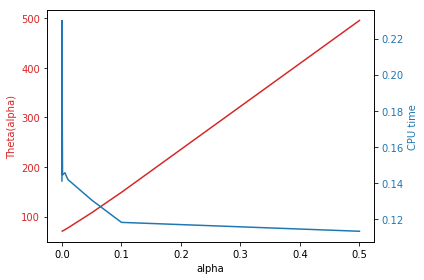

In [22]:
t1 = np.array(t)[:,0]
data1 = np.array(t)[:,1]
data2 = np.array(t)[:,2]

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('alpha')
ax1.set_ylabel('Theta(alpha)', color=color)
ax1.plot(t1, data1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('CPU time', color=color)
ax2.plot(t1, data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()

Except for some occasionnal fluctuations due to bad experimental conditions, we have the expected tradeoff.

### 3.3) Going further : an attempt to close the loop and to detect the densest k-subgraph

In this part, we take into account the fact that the article published by Malick and Roupin aimed to give an upper bound to the integrality gap throuh new SDP relaxations. But eventually the original problem, which is finding the densest k-subgraph, disappears in the article and in the relaxation. We humbly propose our own routine to come back to the original problem and submit it to your advice and opinion.

**Recovering the densest k-subgraph in a small Erdos Renyi graph**

We implement a simple branch and bound algorithm to approximate the true soluton of the problem from the relaxated SDP solution. 

To asses the MR algorithm we should compute the SDP bounds and then compare with our solution. Instead, we are interested here in getting at least an approximate solution for the original problem.

Since we do not have access to the true solution of the DkS for large random Erdos-Renyi graphs, what we propose first is a simple procedure to assess the algorithm on some small graphs :
- Generate a small Erdos-Renyi graph,
- Run the algorithm and obtain the $\hat{X} = \hat{xx^\top}$ with $\hat{X}_{ij} \in [0,1]$,
- Convert the $X_{ij}$ in $\{0,1\}$ using the following rule : set $\hat{X}'_{ij} = 1$ if $\hat{X}_{ij} \geq a$ starting from $a=1$ and decreasing the threshold until we have $k$ connected nodes in the graph.
- Keep the original adjency matrix restricted to the set of nodes in $\hat{X}'$, dropping or not wrong edges/vertices and adding the missing ones.
- Plot and compare.

In [7]:
## A simple rounding algorithm applied to small graphs :

# Step 1) Increase the threshold on xx^t until at least k nodes are included
# Step 2) Prune and correct : connected version (= restrict the original adjency matrix to these nodes and delete/add wrong/missing edges),
#                             non-connected version (= delete any solution vertice which have a wrong node in the SDP solution)
# Step 3) Plot the differences.

# Find the 6-Densest subgrah among the Erdos-Renyi graph : G(8,0.4)

seed = 123
sample_len = 5 # number of repetitions of the optimization procedure

n, p, k, alpha = list([8, 0.4, 6, 0.00001]) # graph parameters
n = int(n)
k = int(k)

# Define the graph and its adjacency matrix    
G = nx.fast_gnp_random_graph(n,p,seed=seed)
W = nx.adjacency_matrix(G).todense()

# Define the graph and its adjacency matrix   
Q, Q_tuple = all_Q(n,W,k)
Ei_tuple = [E_ij(n+1, i+1, i+1) for i in range(n+1)]

X = Variable((n+1,n+1), PSD=True)
obj = Maximize((sum(multiply(Q,X)) - alpha * (norm(X,"fro") ** 2 - (n+1) ** 2)))
constant = 4 * k - 2 * n
constraints = [sum(multiply(Q_tuple[j], X)) == constant for j in range(n+1)] + \
                  [sum(multiply(Ei_tuple[i], X)) == 1 for i in range(n+1)]

#Run several optimizations so that the results presented are more stable    
sol = np.zeros(sample_len)
arg_sol = list()
speed = np.zeros(sample_len)

for i in range(sample_len):
    prob = Problem(obj, constraints)

    start = time.time()
    sol[i] = prob.solve(solver=SCS)
    speed[i] = time.time() - start
    arg_sol.append(X.value)

#[np.mean(sol), np.mean(speed), np.mean(arg_sol, axis = 0)])

In [8]:
# Rounding : keep only weights whose values are sufficiently close to 1
def rounding(Xhat, step_size, n, k):
    """Function that converts xx^T in a 0/1 matrix using a decreasing threshold from 1 to 0 (see step-size)."""
    grid = np.arange(0,1.,step_size)[::-1]
    inf = True
    i = 0
    
    while inf:
        Xnew = np.array(pd.DataFrame((Xhat >= grid[i])*1))[1:,1:]
        Xnew[Xnew==-0]=0
        a = np.sum(Xnew, axis=1)
        indic = len(a[a!=1])
        inf = (indic < k)
        i += 1
    
    if indic==k:
        Xnew = np.array(pd.DataFrame((Xhat >= grid[i-1])*1))[1:,1:]
        Xnew[Xnew==-0]=0
        a = np.sum(Xnew, axis=1)
        indic = len(a[a!=1])
    elif indic>k:
        print("Step_size not tight enough") # in that case one could take the smallest possible value for indic and then prune the tree by increasing density
        Xnew = np.array(pd.DataFrame((Xhat >= grid[i-2])*1))[1:,1:]
        Xnew[Xnew==-0]=0
        a = np.sum(Xnew, axis=1)
        indic = len(a[a!=1])
        
    return Xnew

a = rounding(np.mean(arg_sol, axis = 0), 0.05, 8, 6)

print("\nAdjency matrix \n\n" , W)
print("\n\nApproximate solution \n\n",a)


Adjency matrix 

 [[0 1 1 1 0 1 0 1]
 [1 0 0 1 0 0 0 1]
 [1 0 0 0 0 1 1 0]
 [1 1 0 0 1 1 1 1]
 [0 0 0 1 0 0 1 1]
 [1 0 1 1 0 0 1 0]
 [0 0 1 1 1 1 0 1]
 [1 1 0 1 1 0 1 0]]


Approximate solution 

 [[1 0 0 1 0 0 1 1]
 [0 1 0 0 0 0 0 1]
 [0 0 1 0 0 0 0 0]
 [1 0 0 1 0 0 1 1]
 [0 0 0 0 1 0 0 1]
 [0 0 0 0 0 1 0 0]
 [1 0 0 1 0 0 1 1]
 [1 1 0 1 1 0 1 1]]


Original graph


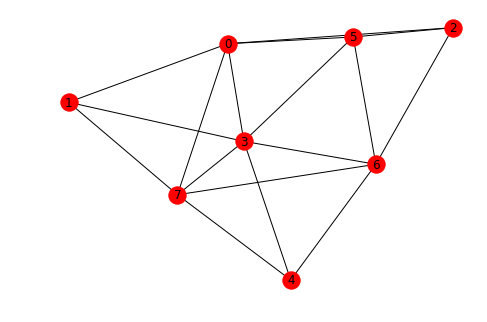

Rounded solution


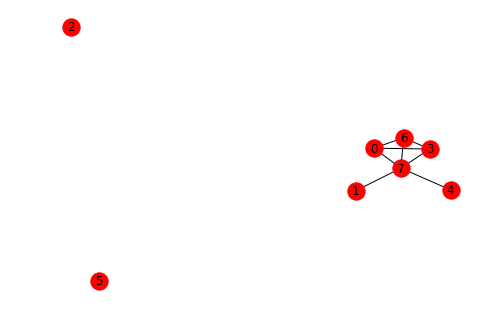

In [71]:
# Solution before applying step 2)
SOL = nx.from_numpy_matrix(a) 

print("Original graph")
nx.draw(G, with_labels=True)
plt.show()

print("Rounded solution")
nx.draw(SOL, with_labels=True)
plt.show()

We observe that the algorithm recovers the vertices of a k-densest subgraph but does not retrieve all the corresponding edges. We implement therefore the following rounding algorithm to get closer to the true solution of the problem.

In [9]:
# Function that takes the vertices candidates and eliminates those which have inconsistent edges.
def prune(W, Xnew, n, connected=True):
    """Prune the solution. Function that take the vertices candidates and eliminate those which have inconsistent edges.
    `W' : original adjency matrix of the problem;
    `Xnew' : roundex solution to the problem;
    `n' : dimension of the original problem (number of vertices);
    `connected' : True means that we retain only the vertices which are connected in the solution 
                  (and add/remove missing/wrong edges)
                  False means that we retain only the vertices which are connected in the solution and without wrong edges .
    """
    valid_nodes = np.zeros(n)
    
    if connected:
        for i in range(n): 
            valid_nodes[i] = 1
            tag = True
            for j in range(n):
                if tag:
                    if np.sum(Xnew[i,:])==1:
                        valid_nodes[i] = 0
                        tag = False
        
        nodes = np.where(valid_nodes)[0]
        nodes_c = np.where(valid_nodes==False)[0]

        edge_list = list() 
        instru = np.where(a - np.eye(n) ==1) # edges de la solution SDPs
        instru_c = np.where(W - np.eye(n) ==1) # edges actifs dans le vrai graphe
        
        true_edges = list()
        for j in range(len(instru_c[0])):
            true_edges.append(np.array([instru_c[0][j], instru_c[1][j]]))
            
        for elem in nodes_c: # remove connections whose nodes are not in the SDP solution
            if elem==nodes_c[0]:
                x_axis0 = instru[0][(instru[0] != elem) * (instru[1] != elem)]
                y_axis0 = instru[1][(instru[0] != elem) * (instru[1] != elem)]
                i=0
            else:
                i = np.where(nodes_c==elem)[0][0]
                exec("x_axis"+str(i)+" = x_axis"+str(i-1)+"[(x_axis"+str(i-1)+"!=elem) * (y_axis"+str(i-1)+" !=elem)]")
                exec("y_axis"+str(i)+" = y_axis"+str(i-1)+"[(x_axis"+str(i-1)+"!=elem) * (y_axis"+str(i-1)+" !=elem)]")
        
        for j in range(len(instru[0])):
            exec("edge_list.append(np.array([x_axis"+str(i)+"[j], y_axis"+str(i)+"[j]]))")
        
        edge_list_bis = list()     
        for elem1 in edge_list: # remove wrong solution edges
            i = 0
            for elem2 in true_edges:
                if (elem1==elem2).all():
                    i +=1
            if i>0:
                edge_list_bis.append(elem1)
            edge_list=edge_list_bis
                
        edge_list_c = list() # add missing edges of the graph for the retained solution vertices

        for elem in nodes_c: # remove wrong vertices outside the solution
            if elem==nodes_c[0]:
                x_axis_c0 = instru_c[0][(instru_c[0] != elem) * (instru_c[1] != elem)]
                y_axis_c0 = instru_c[1][(instru_c[0] != elem) * (instru_c[1] != elem)]
                i = 0
            else:
                i = np.where(nodes_c==elem)[0][0]
                exec("x_axis_c"+str(i)+" = x_axis_c"+str(i-1)+"[(x_axis_c"+str(i-1)+"!=elem) * (y_axis_c"+str(i-1)+" !=elem)]")
                exec("y_axis_c"+str(i)+" = y_axis_c"+str(i-1)+"[(x_axis_c"+str(i-1)+"!=elem) * (y_axis_c"+str(i-1)+" !=elem)]")
 
        for j in range(len(eval("x_axis_c"+str(i)))):
            exec("edge_list_c.append(np.array([x_axis_c"+str(i)+"[j], y_axis_c"+str(i)+"[j]]))")
            
        edge_list_c_bis = list() # remove edges in the solution

        for elem1 in edge_list_c:
            i = 0
            for elem2 in edge_list:
                if (elem1==elem2).all():
                    i +=1
            if i==0:
                edge_list_c_bis.append(elem1)
                
        edge_list_c = edge_list_c_bis
   
    else:
        A = (Xnew!=W)
        for i in range(n): 
            if np.sum(A[i,:])==0:
                valid_nodes[i] = 1
            else:
                valid_nodes[i] = 0

        nodes = np.where(valid_nodes)[0]
        nodes_c = np.where(valid_nodes==False)[0]
        
        edge_list = list() # return original graph with vertices which do not have wrong predicted edge
        instru = np.where(W - np.eye(n) ==1)
        
        for elem in nodes_c: 
            if elem==nodes_c[0]:
                x_axis0 = instru[0][(instru[0] != elem) * (instru[1] != elem)]
                y_axis0 = instru[1][(instru[0] != elem) * (instru[1] != elem)]
                i=0
            else:
                i = np.where(nodes_c==elem)[0][0]
                exec("x_axis"+str(i)+" = x_axis"+str(i-1)+"[(x_axis"+str(i-1)+"!=elem) * (y_axis"+str(i-1)+" !=elem)]")
                exec("y_axis"+str(i)+" = y_axis"+str(i-1)+"[(x_axis"+str(i-1)+"!=elem) * (y_axis"+str(i-1)+" !=elem)]")
        
        for j in range(len(eval("x_axis"+str(i)))):
            exec("edge_list.append(np.array([x_axis"+str(i)+"[j], y_axis"+str(i)+"[j]]))")
        
        edge_list_c = []
        
    return nodes, valid_nodes, W[valid_nodes.astype(int), valid_nodes.astype(int)], edge_list, edge_list_c

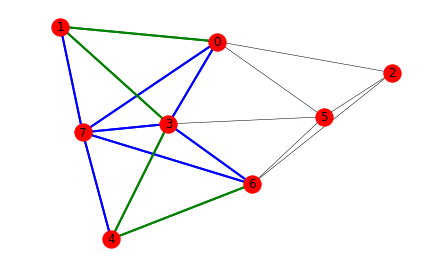

In [73]:
# Plot the rounded solution 
nodes, valid_nodes, subgraph, edge_list, edge_list_c = prune(W + np.eye(n),a,n=n, connected = True)

pos = nx.spring_layout(G)

# Draw the graph
nx.draw_networkx_nodes(G, pos)
nx.draw_networkx_labels(G, pos)
nx.draw_networkx_edges(G, pos, edge_color='k', width=0.5) # show all edges, thin lines
nx.draw_networkx_edges(G, pos, edgelist= edge_list, edge_color='b', width=2) # highlight edges found by solution
nx.draw_networkx_edges(G, pos, edgelist=edge_list_c, edge_color='g', width=2) # highlight final edges after rounding


# Export the graph
plt.axis('off')
plt.tight_layout()
plt.savefig('First_test_6DkS.eps', format='eps', dpi=1000)

In *blue* we have the rounded solution where we have removed the incorrect edges and added the missing edges (in *green*) for the set of k vertices given by the algorithm.

It is clear that there is not a unique solution in that case but still the algorithm and the rounding solution are able to find a true solution of the problem.

[array([0, 2], dtype=int64), array([0, 5], dtype=int64), array([0, 7], dtype=int64), array([0, 8], dtype=int64), array([ 0, 11], dtype=int64), array([ 0, 17], dtype=int64), array([2, 0], dtype=int64), array([2, 5], dtype=int64), array([5, 0], dtype=int64), array([5, 2], dtype=int64), array([ 5, 10], dtype=int64), array([ 5, 17], dtype=int64), array([7, 0], dtype=int64), array([ 7, 14], dtype=int64), array([ 7, 17], dtype=int64), array([8, 0], dtype=int64), array([ 8, 11], dtype=int64), array([ 8, 14], dtype=int64), array([10,  5], dtype=int64), array([11,  0], dtype=int64), array([11,  8], dtype=int64), array([11, 14], dtype=int64), array([14,  7], dtype=int64), array([14,  8], dtype=int64), array([14, 11], dtype=int64), array([17,  0], dtype=int64), array([17,  5], dtype=int64), array([17,  7], dtype=int64)]


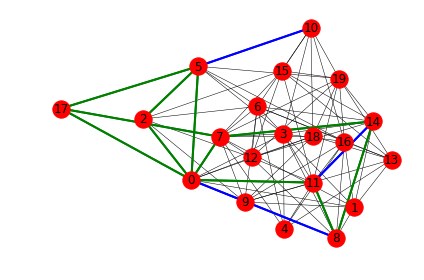

In [87]:
# Find the 10-Densest subgrah among the Erdos-Renyi graph : G(20,0.4)

seed = 123
sample_len = 5 # number of repetitions of the optimization procedure

n, p, k, alpha = list([20, 0.4, 10, 0.00001]) # graph parameters
#n, p, k, alpha = list([20,0.2,10,0.00001]) 
n = int(n)
k = int(k)

# Define the graph and its adjacency matrix    
G = nx.fast_gnp_random_graph(n,p,seed=seed)
W = nx.adjacency_matrix(G).todense()

# Define the graph and its adjacency matrix   
Q, Q_tuple = all_Q(n,W,k)
Ei_tuple = [E_ij(n+1, i+1, i+1) for i in range(n+1)]

X = Variable((n+1,n+1), PSD=True)
obj = Maximize((sum(multiply(Q,X)) - alpha * (norm(X,"fro") ** 2 - (n+1) ** 2)))
constant = 4 * k - 2 * n
constraints = [sum(multiply(Q_tuple[j], X)) == constant for j in range(n+1)] + \
                  [sum(multiply(Ei_tuple[i], X)) == 1 for i in range(n+1)]

#Run several optimizations so that the results presented are more stable    
sol = np.zeros(sample_len)
arg_sol = list()
speed = np.zeros(sample_len)

for i in range(sample_len):
    prob=Problem(obj, constraints)

    start = time.time()
    sol[i] = prob.solve(solver=SCS)
    speed[i] = time.time() - start
    arg_sol.append(X.value)

a = rounding(np.mean(arg_sol, axis = 0), 0.0001, 20, 10)

nodes, valid_nodes, subgraph, edge_list, edge_list_c = prune(W + np.eye(n),a,n=n, connected = True)

pos = nx.spring_layout(G)

# Draw the graph
nx.draw_networkx_nodes(G, pos)
nx.draw_networkx_labels(G, pos)
nx.draw_networkx_edges(G, pos, edge_color='k', width=0.5) # show all edges, thin lines
nx.draw_networkx_edges(G, pos, edgelist= edge_list, edge_color='b', width=2) # highlight edges found by solution
nx.draw_networkx_edges(G, pos, edgelist=edge_list_c, edge_color='g', width=2) # highlight final edges after rounding


# Export the graph
plt.axis('off')
plt.tight_layout()
plt.savefig('First_test_10DkS20_h.eps', format='eps', dpi=1000)

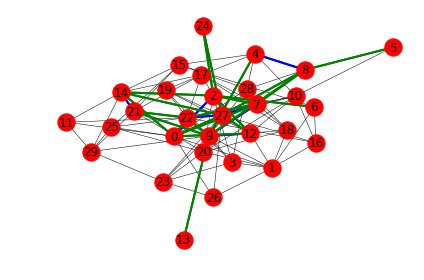

In [83]:
n, p, k, alpha = list([30,0.2,15,0.00001]) 
n = int(n)
k= int(k)

# Define the graph and its adjacency matrix    
G = nx.fast_gnp_random_graph(n,p,seed=seed)
W = nx.adjacency_matrix(G).todense()

# Define the graph and its adjacency matrix   
Q, Q_tuple = all_Q(n,W,k)
Ei_tuple = [E_ij(n+1,i+1,i+1) for i in range(n+1)]

X = Variable((n+1,n+1),PSD=True)
obj = Maximize((sum(multiply(Q,X))-alpha*(norm(X,"fro")**2-(n+1)**2)))
constant = 4*k - 2*n
constraints = [sum(multiply(Q_tuple[j],X)) == constant for j in range(n+1)] + \
                  [sum(multiply(Ei_tuple[i],X)) == 1 for i in range(n+1)]

#Run several optimizations so that the results presented are more stable    
sol = np.zeros(sample_len)
arg_sol = list()
speed = np.zeros(sample_len)

for i in range(sample_len):
    prob=Problem(obj,constraints)

    start = time.time()
    sol[i] = prob.solve(solver=SCS)
    speed[i] = time.time()-start
    arg_sol.append(X.value)

#[np.mean(sol), np.mean(speed), np.mean(arg_sol, axis = 0)])

a = rounding(X.value, 0.00001, 30, 15)

nodes, valid_nodes, subgraph, edge_list, edge_list_c = prune(W + np.eye(n),a,n=n, connected = True)

pos = nx.spring_layout(G)

# Draw the graph
nx.draw_networkx_nodes(G, pos)
nx.draw_networkx_labels(G, pos)
nx.draw_networkx_edges(G, pos, edge_color='k', width=0.5) # show all edges, thin lines
nx.draw_networkx_edges(G, pos, edgelist= edge_list, edge_color='b', width=2) # highlight edges found by solution
nx.draw_networkx_edges(G, pos, edgelist=edge_list_c, edge_color='g', width=2) # highlight final edges after rounding


# Export the graph
plt.axis('off')
plt.tight_layout()
plt.savefig('First_test_15DkS30.eps', format='eps', dpi=1000)

Step_size not tight enough


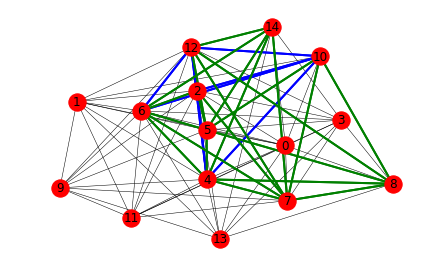

In [45]:
n, p, k, alpha = list([15,0.7,10,0.00001]) 
n = int(n)
k= int(k)

# Define the graph and its adjacency matrix    
G = nx.fast_gnp_random_graph(n,p,seed=seed)
W = nx.adjacency_matrix(G).todense()

# Define the graph and its adjacency matrix   
Q, Q_tuple = all_Q(n,W,k)
Ei_tuple = [E_ij(n+1,i+1,i+1) for i in range(n+1)]

X = Variable((n+1,n+1),PSD=True)
obj = Maximize((sum(multiply(Q,X))-alpha*(norm(X,"fro")**2-(n+1)**2)))
constant = 4*k - 2*n
constraints = [sum(multiply(Q_tuple[j],X)) == constant for j in range(n+1)] + \
                  [sum(multiply(Ei_tuple[i],X)) == 1 for i in range(n+1)]

#Run several optimizations so that the results presented are more stable    
sol = np.zeros(sample_len)
arg_sol = list()
speed = np.zeros(sample_len)

for i in range(sample_len):
    prob=Problem(obj,constraints)

    start = time.time()
    sol[i] = prob.solve(solver=SCS)
    speed[i] = time.time()-start
    arg_sol.append(X.value)

#[np.mean(sol), np.mean(speed), np.mean(arg_sol, axis = 0)])

a = rounding(X.value, 0.0000001, 15, 10)

nodes, valid_nodes, subgraph, edge_list, edge_list_c = prune(W + np.eye(n),a,n=n, connected = True)

pos = nx.spring_layout(G)

# Draw the graph
nx.draw_networkx_nodes(G, pos)
nx.draw_networkx_labels(G, pos)
nx.draw_networkx_edges(G, pos, edge_color='k', width=0.5) # show all edges, thin lines
nx.draw_networkx_edges(G, pos, edgelist= edge_list, edge_color='b', width=2) # highlight edges found by solution
nx.draw_networkx_edges(G, pos, edgelist=edge_list_c, edge_color='g', width=2) # highlight final edges after rounding


# Export the graph
plt.axis('off')
plt.tight_layout()
plt.savefig('First_test_10DkS15.eps', format='eps', dpi=1000)

### Recovering the densest k subgraph in a large deterministic graph but with very few well connected nodes

Now, we propose to build a large graph but with few connected coponents and a unique path. By building th general graph deterministically, this allows us to know which is the densest k-subgraph.

This is to assess whether the algorithm is robust to dimension.

More precisely we are going to build a fully-connected graph so that there are a small number of cliques and then a very long path of nodes connected one after the other.

array([], shape=(0, 0), dtype=float64)

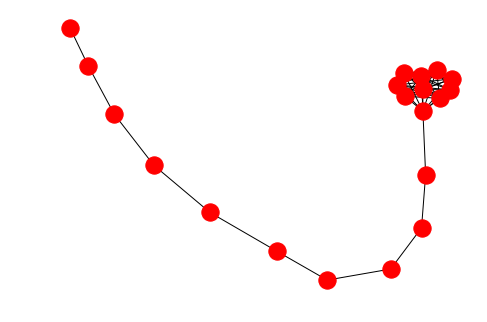

In [30]:
n = 20

design = np.ndarray(shape=(n,n), buffer=np.zeros(n ** 2))
design[:10,:10] = np.ones(10)
design[9,10] = 1 

for i in range(10, n-2):
    design[i,:] = np.concatenate([np.zeros(i-1), \
           np.ones(1), np.zeros(1),np.ones(1), np.zeros(n-i-2)])
design[n-2,n-3]=1
design[n-1,n-2]=1
design[n-2,n-1]=1

G = nx.from_numpy_matrix(design)
nx.draw(G) 

Step_size not tight enough

Adjency matrix 

 [[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0

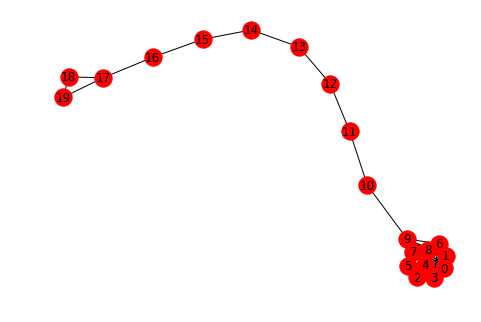

Rounded solution


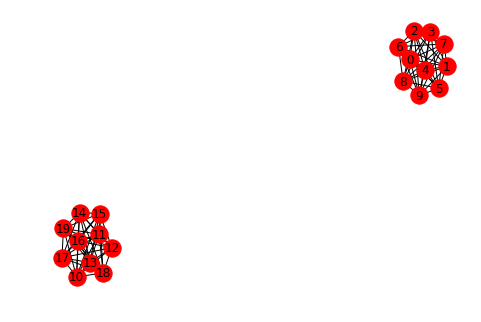

In [45]:
# Find the 10-Densest subgrah among the large graph
n, k = 20, 10 # The final goal is to run with a large n but can takes hours

W = nx.adjacency_matrix(G).todense()

Q, Q_tuple = all_Q(n,W,k)
Ei_tuple = [E_ij(n+1,i+1,i+1) for i in range(n+1)]

X = Variable((n+1,n+1),PSD=True)
obj = Maximize((sum(multiply(Q,X))-alpha*(norm(X,"fro")**2-(n+1)**2)))
constant = 4*k - 2*n
constraints = [sum(multiply(Q_tuple[j],X)) == constant for j in range(n+1)] + \
                  [sum(multiply(Ei_tuple[i],X)) == 1 for i in range(n+1)]

#Run several optimizations so that the results presented are more stable    
sol = np.zeros(sample_len)
arg_sol = list()
speed = np.zeros(sample_len)

for i in range(sample_len):
    prob=Problem(obj,constraints)

    start = time.time()
    sol[i] = prob.solve(solver=SCS)
    speed[i] = time.time()-start
    arg_sol.append(X.value)

#print([np.mean(sol), np.mean(speed), np.mean(arg_sol, axis = 0)])

a = rounding(np.mean(arg_sol, axis = 0), 0.000000001, n=n,k=k )

print("\nAdjency matrix \n\n" , W)
print("\n\nApproximate solution \n\n",a)

# Solution before applying step 2)
SOL = nx.from_numpy_matrix(a) 

print("Original graph")
nx.draw(G, with_labels=True)
plt.show()

print("Rounded solution")
nx.draw(SOL, with_labels=True)
plt.show()

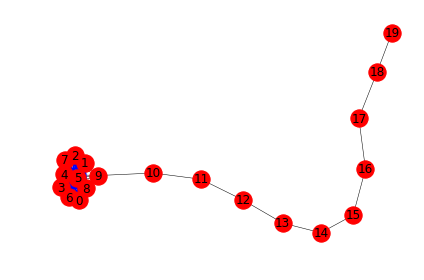

In [27]:
## Solution

nodes, valid_nodes, subgraph, edge_list, edge_list_c = prune(W,a,n=n, connected = False)

pos = nx.spring_layout(G)

# Draw the graph
nx.draw_networkx_nodes(G, pos)
nx.draw_networkx_labels(G, pos)
nx.draw_networkx_edges(G, pos, edge_color='k', width=0.5) # show all edges, thin lines
nx.draw_networkx_edges(G, pos, edgelist= edge_list, edge_color='b', width=2) # highlight edges found by solution
nx.draw_networkx_edges(G, pos, edgelist=edge_list_c, edge_color='g', width=2) # highlight final edges after rounding

# Export the graph
plt.axis('off')
plt.tight_layout()
plt.savefig('First_test_10DkS_deter.eps', format='eps', dpi=1000)

The second version of the algorithm gets the true solution (except one vertice : the 9th). 

Let us look at a similar graph but which have another smaller clique.

Step_size not tight enough

Adjency matrix 

 [[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0

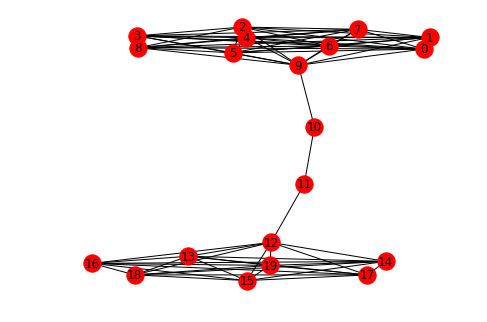

Rounded solution


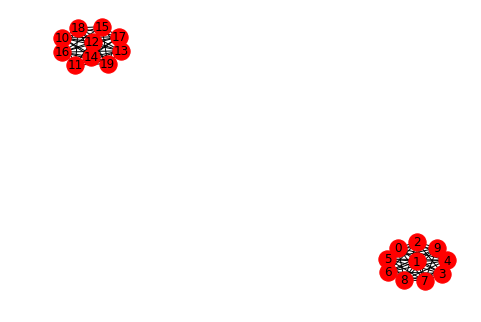

In [47]:
# Find the 10-Densest subgrah among the large graph
n, k = 20, 10 # The final goal is to run with a large n but can takes hours

W[12:20,12:20] = np.ndarray(shape=(8,8), buffer=np.ones(8**2))
G = nx.from_numpy_matrix(W)
W = nx.adjacency_matrix(G).todense()

Q, Q_tuple = all_Q(n,W,k)
Ei_tuple = [E_ij(n+1,i+1,i+1) for i in range(n+1)]

X = Variable((n+1,n+1),PSD=True)
obj = Maximize((sum(multiply(Q,X))-alpha*(norm(X,"fro")**2-(n+1)**2)))
constant = 4*k - 2*n
constraints = [sum(multiply(Q_tuple[j],X)) == constant for j in range(n+1)] + \
                  [sum(multiply(Ei_tuple[i],X)) == 1 for i in range(n+1)]

#Run several optimizations so that the results presented are more stable    
sol = np.zeros(sample_len)
arg_sol = list()
speed = np.zeros(sample_len)

for i in range(sample_len):
    prob=Problem(obj,constraints)

    start = time.time()
    sol[i] = prob.solve(solver=SCS)
    speed[i] = time.time()-start
    arg_sol.append(X.value)

#print([np.mean(sol), np.mean(speed), np.mean(arg_sol, axis = 0)])

a = rounding(np.mean(arg_sol, axis = 0), 0.000000001, n=n,k=k )

print("\nAdjency matrix \n\n" , W)
print("\n\nApproximate solution \n\n",a)

# Solution before applying step 2)
SOL = nx.from_numpy_matrix(a) 

print("Original graph")
nx.draw(G, with_labels=True)
plt.show()

print("Rounded solution")
nx.draw(SOL, with_labels=True)
plt.show()

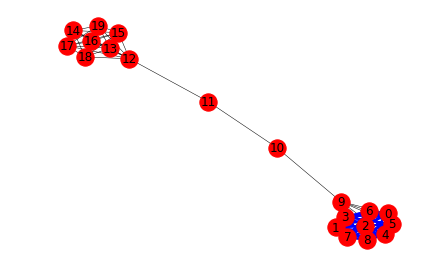

In [48]:
## Solution :

nodes, valid_nodes, subgraph, edge_list, edge_list_c = prune(W,a,n=n, connected = False)

pos = nx.spring_layout(G)

# Draw the graph
nx.draw_networkx_nodes(G, pos)
nx.draw_networkx_labels(G, pos)
nx.draw_networkx_edges(G, pos, edge_color='k', width=0.5) # show all edges, thin lines
nx.draw_networkx_edges(G, pos, edgelist= edge_list, edge_color='b', width=2) # highlight edges found by solution
nx.draw_networkx_edges(G, pos, edgelist=edge_list_c, edge_color='g', width=2) # highlight final edges after rounding

# Export the graph
plt.axis('off')
plt.tight_layout()
plt.savefig('First_test_10DkS_deter_mult.eps', format='eps', dpi=1000)

The correct solution is retrieved among the two cliques !

## IV -  What are the limits and how can we use other known problems to address them ?

**Limits :**

- The round regime of the first result is very slow. While there is no doubt that it tells something more on the NP-hardness of the DkS (than just a constant gap), one should be interested in whether the integrality gap in $\Omega\left(\frac{n^{1/4}}{log^3(n)} \right)$ holds for higher relaxaton regimes. Indeed, it is a question raised by the authors at the end of their proof. They conjecture that even $L = n^\epsilon$ does not reduce the latter integrality gap substantially. Better arguments for bounding the number of trees are needed.

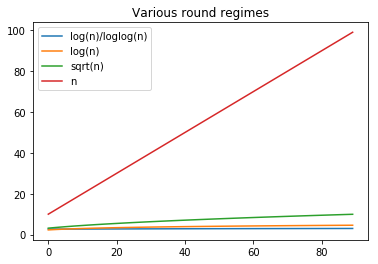

In [5]:
x = np.arange(10,100)
plt.plot(np.log(x)/np.log(np.log(x)))
plt.plot(np.log(x))
plt.plot(np.sqrt(x))
plt.plot(x)
plt.legend(["log(n)/loglog(n)", "log(n)", "sqrt(n)", "n"])
plt.title("Various round regimes")
plt.show()

- Concerning the result on Lasserre relaxations, the authors notice that it could be interesting to match more closely the conjectured integrality gap. Indeed, some subexponential time algorithms yield an integrality gap of $O(n^{1/4-\epsilon})$ after $n^{O(\epsilon)}$ levels of a weaker LP hierarchy than the SA hierarchy The SA being already weaker than the Lasserre hierarchy (see [CT11]), so one good improvment would be to match such a gap for $n^{\Omega(\epsilon)}$ levels. As for the SA, one other refinement would be to examine what happens for polynomial rounds of the Laserre hierarchy with hope to obtain $\Omega(n^{1/4 - \epsilon})$ gaps.

- In both articles the original problem seems a bit drowned in the convex relaxations. In the end, they provide integrality gaps and time-saving algorithms but do not finish the job providing a list of nodes forming the densest subgraph. This can lead to extensions and to a parallel with the commmunity detection problem.

**Parallel**

- In class, we saw the problem of community detections in large graphs. The problem are somewhat similar in the way they are treated. As opposed to $l_1$-normalization where the objective function is convexified, in the densest k-subgraph and in the community detection problem it is the constraint that is convexified. The convexified constraint leads to a solution that does not necessarily verify the condition sought (for us, the matrix $XX^T$ can have a rank higher than 1), so there is a need to find a routine closing the loop. In the community detection problem, there is a last clustering done in order to go back to the community detection problem. Such ending would be gladly welcome in the densest k-subgraph problem and this is what we tried to achieve in our extension.

## V - References

[BCC+10] Bhaskara, A., Charikar, M., Chlamtac, E., Feige, U. and Vijayaraghavan, A., "Detecting high log-densities: an o(n1=4) approximation for densest ksubgraph", In *Proceedings of the 42nd ACM symposium on Theory of computing*, STOC'10, pages 201-210, New York, NY, USA, 2010. ACM.

[CT 11] Chlamtac E. and Tulsiani, M., "Convex Relaxations and Integrality Gaps", *to appear in Handbook on Semidefinite, Cone and Polynomial Optimization*, http://www.cs.princeton.edu/chlamtac/sdpchapter.pdf, 2011.

[Mal07] Malick, J., "Spherical constraint in Boolean quadratic programming", Journal of Global Optimization, 39(4):609–622, 2007.

[Tul09] Tulsiani, T., "CSP gaps and reductions in the lasserre hierarchy", In *Proceedings of
the 41st ACM symposium on Theory of computing*, pages 303-312, 2009.

[Mal12] Jérôme Malick, Frédéric Roupin. Solving k-cluster problems to optimality with semidefinite programming. Mathematical Programming B, Springer, 2012, 136 (2), pp.279-300, https://hal.archives-ouvertes.fr/hal-00609744/document